In [1]:
# Cell 1: Imports & config

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List, Tuple, Optional

# Match this to the logger (logs/ or tools/)
LOG_DIR = Path("logs")  # or Path("tools")

# Mechanical config (must match firmware)
DEG_PER_STEP = 0.225  # same as in C++

# How many recent logs to analyze
NUM_LOGS_TO_LOAD = 1   # set to 1 for single, >1 to compare

print(f"Log directory: {LOG_DIR.resolve()}")


Log directory: /Users/piyush/code/Rotary-Inverted-Pendulum/tools/logs


In [2]:
# Cell 2: Helpers to find and load logs

from pathlib import Path

def find_log_dir(log_dir: Path) -> Path:
    """Try a few sensible locations for the log directory.

    - If log_dir exists as given, return it.
    - Otherwise search upward from the current working directory and
      return the first parent path containing the requested folder.
    - As a last resort look for a "tools" folder next to the notebook.
    """
    if log_dir.exists():
        return log_dir

    cwd = Path.cwd()
    # Search current working directory and parents (repo-root friendliness)
    for p in [cwd] + list(cwd.parents):
        candidate = p / str(log_dir)
        if candidate.exists():
            print(f"Using log directory: {candidate}")
            return candidate

    # fallback to tools/ (older sessions store logs here)
    candidate = cwd / "tools"
    if candidate.exists():
        print(f"Falling back to: {candidate}")
        return candidate

    # not found
    return log_dir


def list_logs(log_dir: Path) -> List[Path]:
    resolved_dir = find_log_dir(log_dir)
    if not resolved_dir.exists():
        print(f"No logs found. Checked: {log_dir} and parent paths (cwd={Path.cwd()}).")
        return []

    entries = sorted(
        resolved_dir.glob("balance_*.csv"),
        key=lambda f: f.stat().st_mtime,
        reverse=True,
    )

    if not entries:
        print(f"No balance_*.csv files found in {resolved_dir}")

    return entries


def load_log(path: Path) -> pd.DataFrame:
    """Load a single log and add derived columns."""
    df = pd.read_csv(path)
    if df.empty:
        raise ValueError(f"Empty CSV: {path}")

    # Normalize local time
    if "time_s" in df.columns:
        df["t"] = df["time_s"] - df["time_s"].iloc[0]
    else:
        df["t"] = np.arange(len(df)) * 0.008  # fallback: assume dt=8ms

    # Basic sanity: sort by time just in case
    df = df.sort_values("t").reset_index(drop=True)

    # dt between samples
    df["dt"] = df["t"].diff().fillna(0.0)

    # Commanded steps (integral of control_output over time)
    if "control_output" in df.columns:
        df["cmd_steps_inc"] = df["control_output"] * df["dt"]
        df["cmd_steps"] = df["cmd_steps_inc"].cumsum()
        df["cmd_angle_deg"] = df["cmd_steps"] * DEG_PER_STEP
    else:
        df["cmd_steps"] = np.nan
        df["cmd_angle_deg"] = np.nan

    return df

logs = list_logs(LOG_DIR)
if not logs:
    print("No logs found.")
else:
    print("Available logs (newest first):")
    for i, p in enumerate(logs[:10], 1):
        print(f"{i:2d}: {p.name}")


Using log directory: /Users/piyush/code/Rotary-Inverted-Pendulum/logs
Available logs (newest first):
 1: balance_20251124-143641_-dev-tty-usbmodem2101_pendulum-fell.csv
 2: balance_20251124-142728_-dev-tty-usbmodem2101_pendulum-fell.csv
 3: balance_20251124-142046_-dev-tty-usbmodem2101_pendulum-fell.csv
 4: balance_20251124-141525_-dev-tty-usbmodem2101_base-limit.csv
 5: balance_20251124-140603_-dev-tty-usbmodem2101_pendulum-fell.csv
 6: balance_20251124-134718_-dev-tty-usbmodem2101_base-limit.csv
 7: balance_20251124-131945_-dev-tty-usbmodem2101_pendulum-fell.csv
 8: balance_20251124-131831_-dev-tty-usbmodem2101_pendulum-fell.csv
 9: balance_20251124-131005__dev_tty.usbmodem2101_timeout.csv
10: balance_20251124-125516_-dev-tty-usbmodem2101_pendulum-fell.csv


In [3]:
# Cell 3: Load last N logs

if not logs:
    dfs: List[Tuple[str, pd.DataFrame]] = []
else:
    n = min(NUM_LOGS_TO_LOAD, len(logs))
    dfs = []
    for p in logs[:n]:
        try:
            df = load_log(p)
            dfs.append((p.name, df))
        except Exception as e:
            print(f"Skipping {p.name}: {e}")

if not dfs:
    print("No usable logs loaded.")
else:
    print(f"Loaded {len(dfs)} log(s).")
    # For convenience, first log as df
    name0, df0 = dfs[0]
    print(f"Using {name0} as primary for plotting.")


Loaded 1 log(s).
Using balance_20251124-143641_-dev-tty-usbmodem2101_pendulum-fell.csv as primary for plotting.


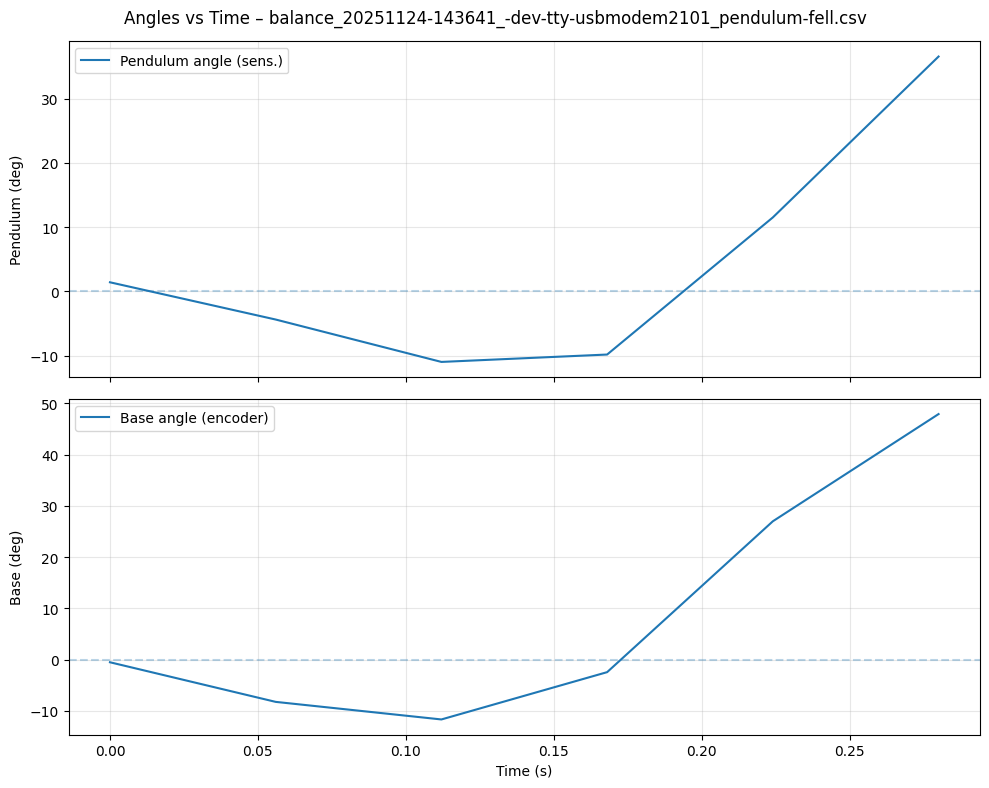

In [4]:
# Cell 4: Plot pendulum & base angle vs time for the primary log

if "df0" not in globals():
    print("No data.")
else:
    df = df0

    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    if "pendulum_deg" in df.columns:
        ax[0].plot(df["t"], df["pendulum_deg"], label="Pendulum angle (sens.)")
        ax[0].axhline(0.0, linestyle="--", alpha=0.3)
        ax[0].set_ylabel("Pendulum (deg)")
        ax[0].legend()
        ax[0].grid(True, alpha=0.3)

    if "base_deg" in df.columns:
        ax[1].plot(df["t"], df["base_deg"], label="Base angle (encoder)")
        ax[1].axhline(0.0, linestyle="--", alpha=0.3)
        ax[1].set_ylabel("Base (deg)")
        ax[1].set_xlabel("Time (s)")
        ax[1].legend()
        ax[1].grid(True, alpha=0.3)

    fig.suptitle(f"Angles vs Time – {name0}")
    plt.tight_layout()
    plt.show()


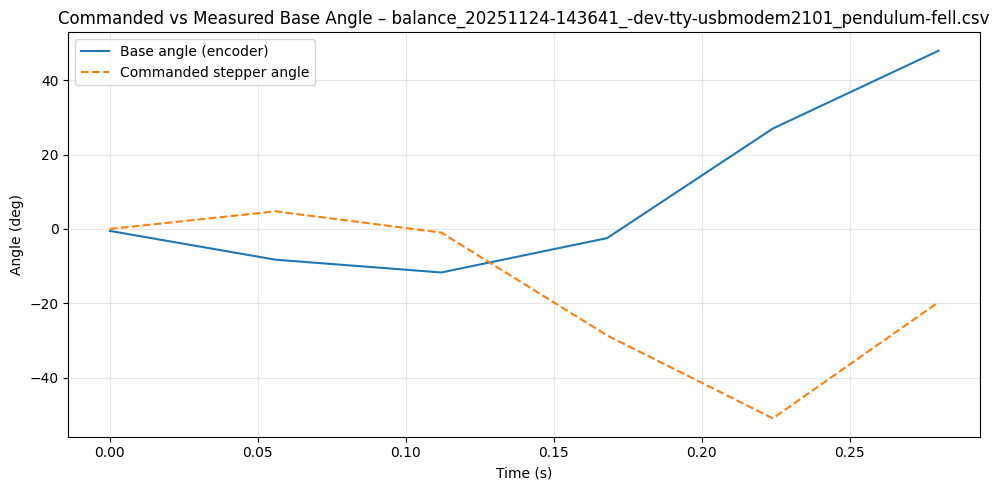

In [5]:
# Cell 5: Commanded vs measured base angle vs time

if "df0" not in globals():
    print("No data.")
else:
    df = df0

    if "base_deg" not in df.columns or "cmd_angle_deg" not in df.columns:
        print("Missing columns for commanded vs measured comparison.")
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(df["t"], df["base_deg"], label="Base angle (encoder)")
        ax.plot(df["t"], df["cmd_angle_deg"], label="Commanded stepper angle", linestyle="--")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle (deg)")
        ax.set_title(f"Commanded vs Measured Base Angle – {name0}")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


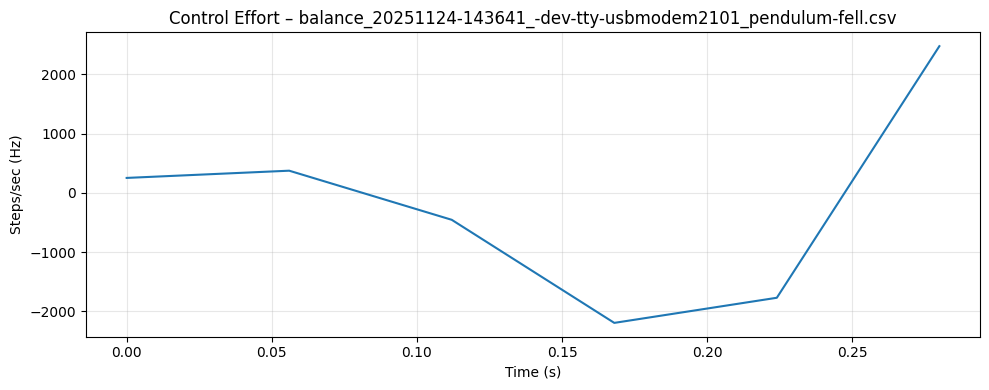

In [6]:
# Cell 6: Control output vs time (microcontroller time vs steps/s)

if "df0" not in globals():
    print("No data.")
else:
    df = df0
    if "control_output" not in df.columns:
        print("No control_output column found.")
    else:
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(df["t"], df["control_output"])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Steps/sec (Hz)")
        ax.set_title(f"Control Effort – {name0}")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


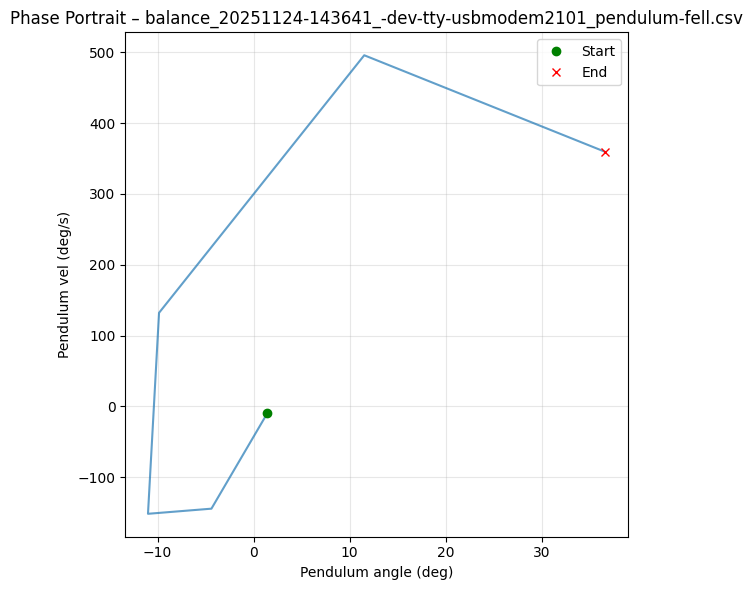

In [7]:
# Cell 7: Phase portrait (pendulum angle vs velocity)

if "df0" not in globals():
    print("No data.")
else:
    df = df0
    if "pendulum_deg" not in df.columns or "pendulum_vel" not in df.columns:
        print("Missing pendulum columns.")
    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot(df["pendulum_deg"], df["pendulum_vel"], alpha=0.7)
        ax.plot(df["pendulum_deg"].iloc[0], df["pendulum_vel"].iloc[0], "go", label="Start")
        ax.plot(df["pendulum_deg"].iloc[-1], df["pendulum_vel"].iloc[-1], "rx", label="End")
        ax.set_xlabel("Pendulum angle (deg)")
        ax.set_ylabel("Pendulum vel (deg/s)")
        ax.set_title(f"Phase Portrait – {name0}")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


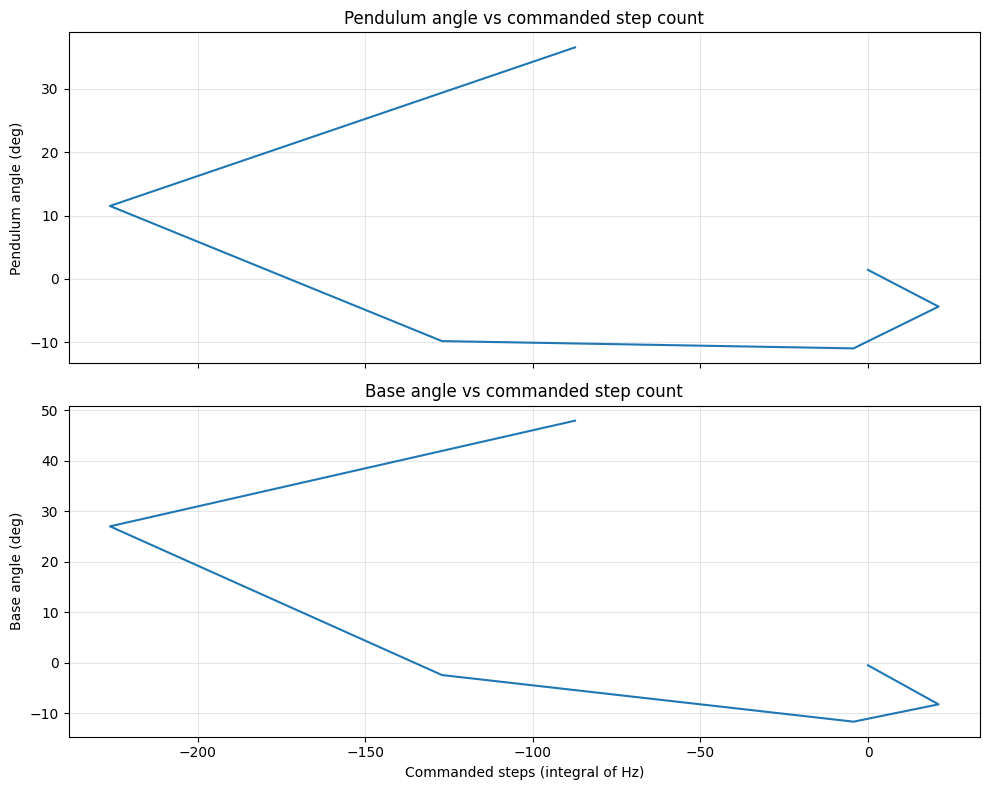

In [8]:
# Cell 8: Angle vs step (what you explicitly asked for)

if "df0" not in globals():
    print("No data.")
else:
    df = df0
    if "cmd_steps" not in df.columns:
        print("cmd_steps not available.")
    else:
        fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

        if "pendulum_deg" in df.columns:
            ax[0].plot(df["cmd_steps"], df["pendulum_deg"])
            ax[0].set_ylabel("Pendulum angle (deg)")
            ax[0].set_title("Pendulum angle vs commanded step count")
            ax[0].grid(True, alpha=0.3)

        if "base_deg" in df.columns:
            ax[1].plot(df["cmd_steps"], df["base_deg"])
            ax[1].set_ylabel("Base angle (deg)")
            ax[1].set_xlabel("Commanded steps (integral of Hz)")
            ax[1].set_title("Base angle vs commanded step count")
            ax[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


In [9]:
# Cell 9: Summary statistics for the primary log

if "df0" not in globals():
    print("No data.")
else:
    df = df0
    print("=== SUMMARY ===")
    print(f"File: {name0}")
    if "t" in df.columns:
        print(f"Duration: {df['t'].iloc[-1]:.3f} s")
    print(f"Samples: {len(df)}")

    if "pendulum_deg" in df.columns:
        print(f"Pendulum angle RMS: {df['pendulum_deg'].std():.3f} deg")
    if "base_deg" in df.columns:
        print(f"Base angle RMS: {df['base_deg'].std():.3f} deg")
    if "control_output" in df.columns:
        print(f"Control output RMS: {df['control_output'].std():.1f} Hz")

    # Gains & reason
    for col, label in [("kp_balance", "Kp"), ("ki_balance", "Ki"), ("kd_balance", "Kd"), ("kp_motor", "Kp_center")]:
        if col in df.columns and not df[col].isna().all():
            print(f"{label} = {df[col].iloc[0]}")
    if "reason" in df.columns:
        print(f"End reason: {df['reason'].iloc[0]}")


=== SUMMARY ===
File: balance_20251124-143641_-dev-tty-usbmodem2101_pendulum-fell.csv
Duration: 0.280 s
Samples: 6
Pendulum angle RMS: 17.944 deg
Base angle RMS: 23.596 deg
Control output RMS: 1685.6 Hz
Kp = 30.0
Ki = 0.0
Kd = 1.5
Kp_center = 0.0
End reason: pendulum_fell
